### Centro Universitário da Fundação Educacional Inaciana "Padre Sabóia de Medeiros" (FEI)


*FEI's Stricto Sensu Graduate Program in Electrical Engineering*

Concentration area: ARTIFICIAL INTELLIGENCE APPLIED TO AUTOMATION AND ROBOTICS

Master's thesis student Andre Luiz Florentino

***

## Check for GPU

In [ ]:
import tensorflow as tf
#tf.config.run_functions_eagerly(True)

print(tf.__version__)

pd = tf.config.experimental.list_physical_devices()
for i in pd:
    print(i)
print('------------------------------------------------------------------------------------------')


print(tf.config.list_physical_devices('GPU'))
# [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

print(tf.test.is_built_with_cuda)
# <function is_built_with_cuda at 0x000001AA24AFEC10>

print(tf.test.gpu_device_name())
# /device:GPU:0

#gvd = tf.config.get_visible_devices()
for j in tf.config.get_visible_devices():
    print(j)
# PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
# PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')

physical_devices = tf.config.experimental.list_physical_devices()
tf.config.experimental.set_memory_growth(physical_devices[2], True)

# Chapter 6: Neural networks

***

## Importe modules

In [ ]:
import librosa
import os
import warnings
import itertools
import time
import sys
import pickle

import pandas     as pd
import seaborn    as sns
import numpy      as np

from matplotlib  import pyplot  as plt
from keras       import backend as K

from tqdm                        import tqdm
from collections                 import Counter

from sklearn                     import metrics
from sklearn.model_selection     import train_test_split
from sklearn.metrics             import confusion_matrix, classification_report
from sklearn.decomposition       import PCA

from tensorflow                  import keras
from tensorflow.keras.models     import Sequential, load_model
from tensorflow.keras.layers     import Dense, Dropout, Conv1D, GlobalAveragePooling1D, MaxPooling1D, Flatten, GlobalMaxPooling1D

from keras.callbacks             import ModelCheckpoint, EarlyStopping
from keras.regularizers          import l2


warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

pd.set_option('display.max_columns', 9)
pd.set_option('display.width', 300)
pd.set_option('display.max_colwidth', 120)

cmap_cm   = plt.cm.Blues

In [ ]:
# Globals
current_path = os.getcwd()

# For the picture names
pic_first_name = '06_Neural_network_'

# For Librosa
FRAME_SIZE  = 1024
HOP_LENGTH  = 512
SEED        = 1000
SR          = 22050

## Loading the dataset


In [ ]:
# Select the dataset

opc = 0
while str(opc) not in '1234':
    print()
    print("1-) ESC-10")
    print("2-) BDLib2")
    print("3-) US8K")
    print("4-) US8K_AV")


    opc = input("\nSelect the dataset: ")
    if opc.isdigit():
        opc = int(opc)
    else:
        opc = 0

if opc == 1:

    path        = os.path.join(current_path, "_dataset", "ESC-10")
    path_pic    = os.path.join(current_path, "ESC-10_results")
    path_models = os.path.join(current_path, "ESC-10_saved_models")
    
   
    subfolders  = next(os.walk(path))[1]
    nom_dataset = 'ESC-10' 
    csv_file    = 'ESC-10.csv'
    fold        = '1'

    pkl_features          = 'ESC-10_features_original.pkl'
    pkl_aug_features      = 'ESC-10_features_augmented_no_windowing.pkl'
    pkl_aug_wind_features = 'ESC-10_features_augmented.pkl'

    
if opc == 2:
    
    path        = os.path.join(current_path, "_dataset", "BDLib2")
    path_pic    = os.path.join(current_path, "BDLib2_results")
    path_models = os.path.join(current_path, "BDLib2_saved_models")

    subfolders  = next(os.walk(path))[1]
    nom_dataset = 'BDLib2' 
    csv_file    = 'BDLib2.csv'
    fold        = 'fold-1'

    pkl_features          = 'BDLib2_features_original.pkl'
    pkl_aug_features      = 'BDLib2_features_augmented_no_windowing.pkl'
    pkl_aug_wind_features = 'BDLib2_features_augmented.pkl'

    
if opc == 3:
    
    path        = os.path.join(current_path, "_dataset", "US8K")
    path_pic    = os.path.join(current_path, "US8K_results")
    path_models = os.path.join(current_path, "US8K_saved_models")
    
    subfolders  = next(os.walk(path))[1]
    nom_dataset = 'US8K' 
    csv_file    = 'US8K.csv'
    fold        = '1'
    
    pkl_features          = 'US8K_features_original.pkl'
    pkl_aug_features      = 'US8K_features_augmented_no_windowing.pkl'
    pkl_aug_wind_features = 'US8K_features_windowed.pkl' # augmented and windowed makes no sense. Dataset is already quite large
    

if opc == 4:

    path        = os.path.join(current_path, "_dataset", "US8K_AV")
    path_pic    = os.path.join(current_path, "US8K_AV_results")
    path_models = os.path.join(current_path, "US8K_AV_saved_models")

    subfolders  = next(os.walk(path))[1]
    nom_dataset = 'US8K_AV' 
    csv_file    = 'US8K_AV.csv'
    fold        = '1'

    pkl_features          = 'US8K_AV_features_original.pkl'
    pkl_aug_features      = 'US8K_AV_features_augmented_no_windowing.pkl'
    pkl_aug_wind_features = 'US8K_AV_features_windowed.pkl' # augmented and windowed makes no sense. Dataset is already quite large

In [ ]:
def get_next_file_number(folder: str):
    files = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f)) and f.startswith(pic_first_name)]
    if not files:
        return 1
    else:
        numbers = [int(f.split('.')[0].split('_')[-1]) for f in files]
        return max(numbers) + 1

In [ ]:
from MT_loadDataset import loadDataset

In [ ]:
loadDataset = loadDataset(path)
DB          = loadDataset.db_B

print("\nClasses:\n--------------------")
print(DB["Class_categorical"].value_counts())
print("\nTotal number of unique files..........: ", len(np.unique(DB["File_name"])))
print("Total number of AUDIO files...........: ", len(DB))
DB

In [ ]:
DB.dtypes

In [ ]:
# Analysis of the class balancing

sns.set_style("darkgrid")
gTitle = f'{nom_dataset} - Number of classes = ' + str(len(pd.Series(DB['Class_categorical']).unique()))
g = sns.displot(DB,x='Class_categorical', hue='Class_categorical',height = 5, aspect = 2).set(title=gTitle)
g.set_xticklabels(rotation=90)
g.set_titles('Number of classes')

# Retrieve the axes object from the plot
axes = g.ax

# Iterate over each bar in the plot
for p in axes.patches:
    # Get the coordinates of the bar
    width = p.get_width()
    height = p.get_height()
    cord_x, cord_y = p.get_xy()
    if height > 0:
        axes.annotate(f'{height}', (cord_x + width/2, cord_y + height), ha='center')
        
g._legend.remove()

plt.tight_layout()

In [ ]:
# Read the pkl file with the augmented features extracted

opc = 0
while str(opc) not in '123':
    print()
    print("1-) Features original")
    print("2-) Features augmented")
    print("3-) Features augmented and windowed (US8K is only windowed)")

    opc = input("\nSelect the dataset: ")
    if opc.isdigit():
        opc = int(opc)
    else:
        opc = 0

if opc == 1:
    DB_from_pkl   = pd.read_pickle(os.path.join(path_models, pkl_features))
    model_surname = '_original'

if opc == 2:
    DB_from_pkl   = pd.read_pickle(os.path.join(path_models, pkl_aug_features))
    model_surname = '_augmented'

if opc == 3:
    DB_from_pkl = pd.read_pickle(os.path.join(path_models, pkl_aug_wind_features))
    model_surname = '_windowed'

In [ ]:
DB_from_pkl.dtypes

In [ ]:
total_duration = 0
for audio in DB_from_pkl['Audio']:
    total_duration = total_duration + librosa.get_duration(y=audio)
print('Total duration of the dataset: ' , "{:0.4f} h".format(total_duration / 3600))

In [ ]:
DB_from_pkl

In [ ]:
print(type(DB_from_pkl['Fold'][0][0]))
print(type(DB_from_pkl['Class_OHEV'][0][0]))
print(type(DB_from_pkl['Class_OHEV'][0]))

## Input split

In [ ]:
# Separate 1 fold for validation and create a DB for the training / testing according to the datasets specification

DB_from_pkl_VAL = DB_from_pkl[DB_from_pkl['Fold'] == fold].copy()
DB_from_pkl_TRN = DB_from_pkl[DB_from_pkl['Fold'] != fold].copy()

In [ ]:
print(len(DB_from_pkl_VAL))
print(len(DB_from_pkl_TRN))
print('Total: ', len(DB_from_pkl_VAL) + len(DB_from_pkl_TRN),'\n')

In [ ]:
DB_from_pkl_VAL

In [ ]:
DB_from_pkl_TRN

In [ ]:
for i in DB_from_pkl_TRN.columns:
    print(i)

In [ ]:
# Separating data and labels

X      = DB_from_pkl_TRN.drop(columns=['Audio','Class_categorical','Class_OHEV', 'Fold'])
y      = np.array(DB_from_pkl_TRN.Class_categorical.to_list())
y_OHEV = np.array(DB_from_pkl_TRN.Class_OHEV.to_list())

In [ ]:
# For the augmented dataset (only validation set)

X_val      = DB_from_pkl_VAL.drop(columns=['Audio','Class_categorical','Class_OHEV', 'Fold'])
y_val      = np.array(DB_from_pkl_VAL.Class_categorical.to_list())
y_OHEV_val = np.array(DB_from_pkl_VAL.Class_OHEV.to_list())

In [ ]:
X

In [ ]:
X.describe()

In [ ]:
y

In [ ]:
y_OHEV

In [ ]:
X_statistics = pd.DataFrame({'mean': X.mean(), 'std': X.std(), 'min': X.min(), 'max': X.max()})

X_mean = X_statistics.values[:, 0]
X_std  = X_statistics.values[:, 1]
X_min  = X_statistics.values[:, 2]
X_max  = X_statistics.values[:, 3]

X_norm   =  (X.values - X_min) / (X_max - X_min)

X_normDB = X.apply(lambda x: (x - x.min()) / (x.max() - x.min()))

In [ ]:
RMSE_lst = []
for i in X_norm:
    RMSE_lst.append([i][0][0])
    
print(np.mean(RMSE_lst))

In [ ]:
X_normDB.describe()

In [ ]:
X_standard = (X.values - X_mean) / X_std

X_standardDB = X.apply(lambda x: (x - x.mean()) / x.std())

In [ ]:
RMSE_lst    = []
for i in X_standard:
    RMSE_lst.append([i][0][0])
    
print(np.mean(RMSE_lst))
print(np.std(RMSE_lst))

In [ ]:
X_standardDB.describe()

In [ ]:
X_norm.shape

In [ ]:
X_standard.shape

In [ ]:
y_OHEV.shape

In [ ]:
len(X_norm)

In [ ]:
len(X_standard)

In [ ]:
X_val

In [ ]:
X_val.describe()

In [ ]:
y_OHEV_val

In [ ]:
X_val_norm   =  (X_val.values - X_min) / (X_max - X_min)

In [ ]:
X_val_standard = (X_val.values - X_mean) / X_std

In [ ]:
X_val_norm.shape

In [ ]:
X_val_standard.shape

In [ ]:
y_OHEV_val.shape

In [ ]:
len(y_OHEV_val)

In [ ]:
Counter_val = Counter(map(tuple, y_OHEV_val))
Counter_val

In [ ]:
# Group by the class and get one random sample of each class
k = DB_from_pkl.groupby('Class_categorical')['Class_OHEV'].apply(lambda s: s.sample(1))
print(k)

# Convert the pandas series into a dataframe
temp_k_df = k.reset_index()

# Delete the index from the grouppby result
del temp_k_df['level_1']

# Set the "Class" as the dataframe index
temp_k_df.set_index("Class_categorical", inplace=True)

# Convert the dataframe to a dictionary (Class: Class_encoder)
encoder_dict = temp_k_df["Class_OHEV"].to_dict()
encoder_dict

In [ ]:
nom_classes = list(encoder_dict.keys())
nom_classes

In [ ]:
# Number of classes in the dataset

num_classes = len(encoder_dict.keys())
num_classes

## Neural networks

In [ ]:
del DB_from_pkl_VAL, DB_from_pkl_TRN

In [ ]:
# Separate 1 fold for validation and create a DB for the training / testing

opc = 0
while str(opc) not in '12':
    print()
    print("1-) Normalization")
    print("2-) Standardization")

    opc = input("\nSelect the dataset: ")
    if opc.isdigit():
        opc = int(opc)
    else:
        opc = 0


    DB_from_pkl_VAL = DB_from_pkl[DB_from_pkl['Fold'] == fold].copy()
    DB_from_pkl_TRN = DB_from_pkl[DB_from_pkl['Fold'] != fold].copy()
    
    X      = DB_from_pkl_TRN.drop(columns=['Audio','Class_categorical','Class_OHEV', 'Fold'])
    y      = np.array(DB_from_pkl_TRN.Class_categorical.to_list())
    y_OHEV = np.array(DB_from_pkl_TRN.Class_OHEV.to_list())

    X_val      = DB_from_pkl_VAL.drop(columns=['Audio','Class_categorical','Class_OHEV', 'Fold'])
    y_val      = np.array(DB_from_pkl_VAL.Class_categorical.to_list())
    y_OHEV_val = np.array(DB_from_pkl_VAL.Class_OHEV.to_list())

    X_statistics = pd.DataFrame({'mean': X.mean(), 'std': X.std(), 'min': X.min(), 'max': X.max()})

    X_mean   = X_statistics.values[:, 0]
    X_std    = X_statistics.values[:, 1]
    X_min    = X_statistics.values[:, 2]
    X_max    = X_statistics.values[:, 3]
    
    # Normalization or standardization using values from the training set.
    if opc == 1:
        X_norm     = (X.values - X_min) / (X_max - X_min)
        X_val_norm = (X_val.values - X_min) / (X_max - X_min)
        norm_type  = '_norm'

    if opc == 2:
        X_norm     = (X.values - X_mean) / X_std
        X_val_norm = (X_val.values - X_mean) / X_std
        norm_type  = '_std'

    # Retrieve the indexes used for training the classifiers
    idx_trn = np.genfromtxt(os.path.join(path_models, '_idx_trn_' + nom_dataset + model_surname + '.csv'), delimiter=',', dtype = int)
    idx_tst = np.genfromtxt(os.path.join(path_models, '_idx_tst_' + nom_dataset + model_surname + '.csv'), delimiter=',', dtype = int)

    X_train      = X_norm[idx_trn]
    X_test       = X_norm[idx_tst]
    y_train      = y[idx_trn]
    y_test       = y[idx_tst]
    y_train_OHEV = y_OHEV[idx_trn]
    y_test_OHEV  = y_OHEV[idx_tst]

In [ ]:
print("\n==================================")
print("Training set\n")

print(f'X_train.........: {np.shape(X_train)}')
print(f'y_train.........: {np.shape(y_train)}')
print(f'y_train_OHEV....: {np.shape(y_train_OHEV)}')

print("\n==================================")
print("Testing set\n")

print(f'X_test..........: {np.shape(X_test)}')
print(f'y_test..........: {np.shape(y_test)}')
print(f'y_test_OHEV.....: {np.shape(y_test_OHEV)}')

print("\n==================================")
print("Validation set\n")

print(f'X_val_norm......: {np.shape(X_val_norm)}')
print(f'y_val...........: {np.shape(y_val)}')
print(f'y_OHEV_val......: {np.shape(y_OHEV_val)}')

In [ ]:
# Simple confusion matrix

def simple_conf_matrix(y_true, y_pred, nom_classes, clf, acc):
    
    picture_name = f'{pic_first_name}{get_next_file_number(path_pic):02d}.png'

    conf_matrix = metrics.confusion_matrix(y_true, y_pred)
    title = nom_dataset + model_surname + norm_type + ' - Classifier ' + clf + ' - Validation accuracy: '+ str("{:0.2f} %".format(acc*100))

    plt.figure(figsize = (10,10))
    sns.heatmap(conf_matrix, 
                annot=True, 
                fmt='g', 
                cmap=cmap_cm, 
                annot_kws={"size": 8}, 
                xticklabels=nom_classes, 
                yticklabels=nom_classes)
    plt.title(title, fontsize = 12)
    plt.savefig(os.path.join(path_pic, picture_name))
    plt.show()

In [ ]:
# Plot the confusion matrix

def plot_confusion_matrix(cm, labels, title, cmap, normalize):

    if labels is not None:
        tick_marks = np.arange(len(labels))
        plt.xticks(tick_marks, labels, fontsize=10, rotation=45)
        plt.yticks(tick_marks, labels, fontsize=10)
   
    if cmap is None:
        cmap = plt.get_cmap('Blues')
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black", fontsize = 8)
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black", fontsize = 8)

    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title, fontsize=13)
    plt.colorbar(shrink=1)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(None)
    plt.tight_layout()

## Classifiers

- **Multilayer Perceptron** (MLP) is a type of Artificial Neural Network (ANN) used for supervised learning tasks, including classification, regression, and pattern recognition. It's a feedforward neural network that consists of multiple layers of nodes, including an input layer, one or more hidden layers, and an output layer. Each node, or neuron, in the network is connected to every node in the adjacent layers, and these connections have weights that are adjusted during training. MLP is capable of modeling complex relationships in data, making it suitable for tasks where the relationship between inputs and outputs is non-linear and intricate. It uses activation functions to introduce non-linearity into the network, allowing it to learn and approximate a wide variety of functions. One of the key advantages of MLP is its ability to learn from large and high-dimensional datasets. However, this advantage comes with the cost of increased complexity, making it more challenging to train and requiring careful tuning of hyperparameters like the number of hidden layers, the number of neurons in each layer, and the learning rate. Additionally, MLP is sensitive to feature scaling, and preprocessing techniques such as normalization are often applied to the input data to improve performance.
***
- **Convolutional Neural Networks** (CNNs) are a class of deep learning algorithms specifically designed for processing grid-like data, such as images and videos. CNNs are highly effective in tasks related to computer vision, including image recognition, object detection, and image segmentation. They are characterized by their ability to automatically and adaptively learn spatial hierarchies of features from input data. CNNs consist of multiple layers, including convolutional layers, pooling layers, and fully connected layers. The convolutional layers apply convolution operations to the input data, enabling the network to automatically learn patterns and features from images, such as edges, textures, and more complex structures. The pooling layers downsample the spatial dimensions of the data, reducing computational complexity while retaining important features. Fully connected layers at the end of the network process the learned features and make predictions based on them. One of the significant advantages of CNNs is their ability to capture local patterns and spatial hierarchies of features. By using shared weights and biases in the convolutional layers, CNNs are capable of learning translation-invariant features, making them well-suited for tasks where the spatial arrangement of features in the input data is essential. Additionally, CNNs can automatically learn relevant features from raw pixel values, eliminating the need for manual feature extraction.

In [ ]:
# Number of the dimensions of the input layer

n_dim       = X_norm.shape[1]
n_dim

In [ ]:
# For OHEV

Counter_test = Counter(map(tuple, y_test_OHEV))
Counter_train = Counter(map(tuple, y_train_OHEV))

In [ ]:
print('Training samples')
Counter_train

In [ ]:
print('Testing samples')
Counter_test

### ANN - Grid search for best parameters

In [ ]:
#def create_model():
    
#    model = Sequential()
#    model.add(Dense(n_dim, activation='relu', input_shape=(n_dim,)))
#    model.add(Dropout(0.2))
#    model.add(Dense(375, activation='relu'))
#    model.add(Dropout(0.2))
#    model.add(Dense(num_classes, activation='softmax'))

#    model.compile(loss='MeanSquaredError', optimizer='adam', metrics=['accuracy'])
    
#    return model

In [ ]:
# Grid search for the batch size and epochs

#model = KerasClassifier(build_fn = create_model, verbose=0)

# define the grid search parameters
#batch_size  = [20, 40, 80, 160]
#epochs      = [100, 250, 500]
#param_grid  = dict(batch_size = batch_size, epochs = epochs)
#grid        = GridSearchCV(estimator = model, param_grid = param_grid, n_jobs=-1, cv=3)
#grid_result = grid.fit(X_train, y_train)

# summarize results
#print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
#means  = grid_result.cv_results_['mean_test_score']
#stds   = grid_result.cv_results_['std_test_score']
#params = grid_result.cv_results_['params']

#for mean, stdev, param in zip(means, stds, params):
#    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
#del model
#K.clear_session()

In [ ]:
#from tensorflow.keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta, Adamax, Nadam

In [ ]:
# Grid search for hidden layers, neurons, activation, dropout_rate and optimizer

#def tune_model(hidden_layers, neurons, activation, dropout_rate, optimizer='adam', learning_rate=0.001, momentum=0.9, nesterov=False, rho=0.9, epsilon=1e-07, centered=False, 
#                 initial_accumulator_value=0.1, amsgrad=False, beta_1=0.9, beta_2=0.999):
    
#    model = Sequential()
#    model.add(Dense(units = neurons, activation = activation, input_shape = (n_dim,)))

#    for i in range(hidden_layers):
#        model.add(Dense(units = neurons, activation = activation))
#        model.add(Dropout(dropout_rate))

#    model.add(Dense(units = num_classes, activation = 'sigmoid'))
    
#    if optimizer == 'sgd':
#        optimizer = SGD(lr=learning_rate, momentum=momentum, nesterov=nesterov)
#    elif optimizer == 'rmsprop':
#        optimizer = RMSprop(lr=learning_rate, rho=rho, epsilon=epsilon, centered=centered)
#    elif optimizer == 'adam':
#        optimizer = Adam(lr=learning_rate, beta_1=beta_1, beta_2=beta_2, epsilon=epsilon, amsgrad=amsgrad)
#    elif optimizer == 'adagrad':
#        optimizer = Adagrad(lr=learning_rate, initial_accumulator_value=initial_accumulator_value, epsilon=epsilon)
#    elif optimizer == 'adadelta':
#        optimizer = Adadelta(lr=learning_rate, rho=rho, epsilon=epsilon)
#    elif optimizer == 'adamax':
#        optimizer = Adamax(lr=learning_rate, beta_1=beta_1, beta_2=beta_2, epsilon=epsilon)
#    elif optimizer == 'nadam':
#        optimizer = Nadam(lr=learning_rate, beta_1=beta_1, beta_2=beta_2, epsilon=epsilon)
        
#    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
#    return model

In [ ]:
#hidden_layers  = [1, 2, 3]
#neurons        = [375, 500, 750, 1000]
#activation     = ['relu', 'sigmoid']
#dropout_rate   = [0.1, 0.2, 0.3]
#optimizer      = ['sgd', 'rmsprop', 'adam', 'adagrad', 'adadelta', 'adamax', 'nadam']

#learning_rate  = [0.001, 0.01, 0.1]

#param_grid     = dict(hidden_layers = hidden_layers, 
#                      neurons       = neurons, 
#                      activation    = activation,
#                     dropout_rate  = dropout_rate,
#                      optimizer     = optimizer,
#                      learning_rate = learning_rate)

In [ ]:
#tf.autograph.set_verbosity(0)
#tf.config.set_visible_devices([], 'GPU')

In [ ]:
#model = KerasClassifier(build_fn = tune_model, verbose=1, epochs = 100, batch_size = 80)
#grid  = GridSearchCV(estimator = model, param_grid = param_grid, cv = 3)

In [ ]:
#grid_result = grid.fit(X_train, y_train)

In [ ]:
## summarize results
#print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
#means  = grid_result.cv_results_['mean_test_score']
#stds   = grid_result.cv_results_['std_test_score']
#params = grid_result.cv_results_['params']

#for mean, stdev, param in zip(means, stds, params):
#    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
# ANN (Artificial Neural Network) or MLP (Multi layer Perceptron) using Tensorflow

initializer = keras.initializers.Ones()

def build_ANN_model(model_name: str, neurons: int):
    
    #optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=False)
    optimizer = keras.optimizers.Adam(learning_rate=0.0001, 
                                      beta_1=0.5, 
                                      beta_2=0.999, 
                                      epsilon=1e-07, 
                                      amsgrad=True)
    
    
    model = Sequential(name = model_name)
    model.add(Dense(neurons, activation = 'relu', input_shape = (neurons,), name = 'Input'))

    # First hiden layer with 375 neurons
    model.add(Dense(neurons, activation ='relu', name = 'Hiden_1'))

    # Dropout de 20%
    model.add(Dropout(0.2, name = 'Dropout_1'))
    
    # Second hiden layer with 750 neurons (Kolmogorov's theorem)
    model.add(Dense(n_dim * 2, activation ='relu', name = 'Hiden_2'))

    # Dropout de 20%
    model.add(Dropout(0.2, name = 'Dropout_2'))

    # Final classification layer, with 1 neuron for each output class. Softmax divides the probability of each class.
    model.add(Dense(num_classes, activation='softmax', name = 'Output'))

    model.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])

    return model

In [ ]:
es = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=150, verbose=1, mode='auto', restore_best_weights=True)

if not os.path.exists(path_models):
    os.makedirs(path_models)

filepath       = os.path.join(path_models, 'Model_ANN_weights_0_best' + norm_type + model_surname + '.hdf5')
checkpoint     = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint,es]

In [ ]:
model_ANN = build_ANN_model('ANN_1', neurons = n_dim)
model_ANN.summary()

In [ ]:
tf.keras.utils.plot_model(model_ANN, to_file= os.path.join(path_models, 'Model_ANN' + norm_type + model_surname + '.png'), show_shapes=True)

### Understanding the column "Param":

- 141,000 parameters is the result of 375 neurons with 375 features + 375  bias values
- 141,000 parameters is the result of 375 neurons with 375 features + 375  bias values
- 282,000 parameters is the result of 750 neurons with 375 features + 750 bias values
- 3,755   parameters is the result of 750 neurons with 5 features  + 5  bias values

In [ ]:
print("\n==================================")
print("Training set\n")

print(f'X_train.........: {np.shape(X_train)}')
print(f'y_train.........: {np.shape(y_train)}')
print(f'y_train_OHEV....: {np.shape(y_train_OHEV)}')

print("\n==================================")
print("Testing set\n")

print(f'X_test..........: {np.shape(X_test)}')
print(f'y_test..........: {np.shape(y_test)}')
print(f'y_test_OHEV.....: {np.shape(y_test_OHEV)}')

print("\n==================================")
print("Validation set\n")

print(f'X_val_norm......: {np.shape(X_val_norm)}')
print(f'y_val...........: {np.shape(y_val)}')
print(f'y_OHEV_val......: {np.shape(y_OHEV_val)}')

In [ ]:
y_train_OHEV

In [ ]:
batch_size_ANN = 32
epochs_ANN     = 350

history_ANN    = model_ANN.fit(X_train, y_train_OHEV,
                               batch_size      = batch_size_ANN,
                               epochs          = epochs_ANN,
                               verbose         = 1,
                               validation_data = (X_test, y_test_OHEV),
                               callbacks       = callbacks_list)

In [ ]:
score_ANN = model_ANN.evaluate(X_test, y_test_OHEV, verbose=0, batch_size = 32)
print('Test loss:', score_ANN[0])
print('Test accuracy:', score_ANN[1])

In [ ]:
score_ANN[1]

In [ ]:
picture_name = f'{pic_first_name}{get_next_file_number(path_pic):02d}.png'

fig, ax = plt.subplots(1,2, figsize=(16,8))
fig.suptitle(nom_dataset + norm_type + model_surname + ' - ANN - Training / Testing loss and accuracy', fontsize = 18)
ax[0].plot(history_ANN.history['loss'], color='b', label="Training loss")
ax[0].plot(history_ANN.history['val_loss'], color='r', label="Testing loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True, fontsize = 14)
ax[0].tick_params(axis='x', labelsize=14)
ax[0].tick_params(axis='y', labelsize=14)

ax[1].plot(history_ANN.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history_ANN.history['val_accuracy'], color='r',label="Testing accuracy")
legend = ax[1].legend(loc='best', shadow=True, fontsize = 14)
ax[1].tick_params(axis='x', labelsize=14)
ax[1].tick_params(axis='y', labelsize=14)

fig.tight_layout()
plt.savefig(os.path.join(path_pic, picture_name))

In [ ]:
# save model and architecture to single file (not the best model though)

#model_ANN.save(path_models + "Model_ANN.h5")
#print("Saved model to disk")

In [ ]:
y_pred_ANN = np.argmax(model_ANN.predict(X_val_norm),axis=1)
y_pred_ANN

In [ ]:
y_test_enc = np.argmax(y_OHEV_val, axis=1)
y_test_enc

In [ ]:
metrics_set_ANN = classification_report(y_test_enc, y_pred_ANN, target_names=nom_classes)
print(metrics_set_ANN)

In [ ]:
# Load the model with the highest accuracy

model_ANN_saved = load_model(os.path.join(path_models, 'Model_ANN_weights_0_best' + norm_type + model_surname + '.hdf5'))
model_ANN_saved.summary()

In [ ]:
score_ANN_saved = model_ANN_saved.evaluate(X_val_norm, y_OHEV_val, verbose=1, batch_size = 32)
print('Test loss:', score_ANN_saved[0])
print('Test accuracy:', score_ANN_saved[1])

In [ ]:
y_pred_ANN_saved = np.argmax(model_ANN_saved.predict(X_val_norm),axis=1)
y_pred_ANN_saved

In [ ]:
metrics_set_ANN_saved = classification_report(y_test_enc, y_pred_ANN_saved, target_names=nom_classes)
print(metrics_set_ANN_saved)

In [ ]:
# Simple confusion matrix

picture_name = f'{pic_first_name}{get_next_file_number(path_pic):02d}.png'

conf_matrix = metrics.confusion_matrix(y_test_enc, y_pred_ANN_saved)
title = nom_dataset + norm_type + model_surname + ' - Classifier ANN (best model) - Highest accuracy test: '+ str("{:0.2f}%".format(score_ANN_saved[1]*100))

plt.figure(figsize = (10,10))
sns.heatmap(conf_matrix, 
            annot=True, 
            fmt='g', 
            cmap=cmap_cm, 
            annot_kws={"size": 8}, 
            xticklabels=nom_classes, 
            yticklabels=nom_classes)
plt.title(title, fontsize = 12)
plt.savefig(os.path.join(path_pic, picture_name))
plt.show()

In [ ]:
model_ANN_saved.layers

In [ ]:
for layer in model_ANN_saved.layers:
    print(layer.get_weights())

In [ ]:
weights = model_ANN_saved.get_layer('Output').get_weights()
weights[1]

### CNN 1D

In [ ]:
# CNN (Convolutional Neural Network) using Tensorflow

def build_CNN_1D_model(model_name: str, neurons: int):
    
    model = Sequential(name = model_name)

    # 1st conv layer
    model.add(Conv1D(28, 7, activation = 'relu', input_shape = (neurons, 1), name = 'Conv1D_1'))
    #model.add(MaxPooling1D(3, name = 'MaxPool1D_1'))

    # 2nd conv layer
    model.add(Conv1D(34, 5, activation = 'relu', kernel_regularizer=l2(0.001), bias_regularizer=l2(0.01), padding='same', name = 'Conv1D_2'))
    #model.add(MaxPooling1D(2, name = 'MaxPool1D_2'))
    
    # 3nd conv layer 
    model.add(Conv1D(56, 3, activation = 'relu', kernel_regularizer=l2(0.001), bias_regularizer=l2(0.01), padding='same', name = 'Conv1D_3'))
    model.add(MaxPooling1D(2, name = 'MaxPool1D_3'))
    model.add(Dropout(0.2, name = 'Dropout_1'))
    
    # 4nd conv layer + dropout 20%
    model.add(Flatten())
    model.add(Dense(50, name = 'Dense'))

    # Final classification layer, with 1 neuron for each output class. Softmax divides the probability of each class.
    model.add(Dense(num_classes, activation = 'softmax', name = 'Output'))
    
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adamax', metrics = ['accuracy'])

    return model

In [ ]:
monitor = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=50, verbose=1, mode='auto', restore_best_weights=True)

if not os.path.exists(path_models):
    os.makedirs(path_models)
    
filepath       = os.path.join(path_models, 'Model_CNN_1D_weights_0_best' + norm_type + model_surname + '.hdf5')
checkpoint     = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint, monitor]

In [ ]:
model_CNN_1D = build_CNN_1D_model('CNN_1D', neurons = n_dim)
model_CNN_1D.summary()

In [ ]:
tf.keras.utils.plot_model(model_ANN, to_file= os.path.join(path_models, 'Model_CNN_1D' + norm_type + model_surname + '.png'), show_shapes=True)

### Understanding the column "Param":

1. For `Conv1D` layer:
   - The number of parameters for a `Conv1D` layer is calculated as `(kernel_size * input_channels + 1) * output_channels`, where `kernel_size` is the size of the convolutional kernel, `input_channels` is the number of input channels (1 in this case), and `output_channels` is the number of output channels.

2. For `Dense` layer:
   - The number of parameters for a `Dense` layer is calculated as `(input_units + 1) * output_units`, where `input_units` is the number of input units and `output_units` is the number of output units.
   
3. In the calculation of parameters for a convolutional layer, the term "channels" refers to the number of filters used in that layer.

- 224   parameters is the result of 28 filters * (7 kernels * 1 filter + 1)
- 4,794 parameters is the result of 34 filter * (5 kernels * 28 filters + 1)
- 5,768  parameters is the result of 56 filters * (3 kernels * 34 filters + 1)
- 515,250  parameters is the result of 50 neurons with 10,304 features + 50 bias values
- 255    parameters is the result of 5 neurons with 50 features + 5 bias values

In [ ]:
batch_size_CNN_1D = 32
epochs_CNN_1D     = 150

history_CNN_1D    = model_CNN_1D.fit(X_train[..., np.newaxis], y_train_OHEV,
                                     batch_size      = batch_size_CNN_1D,
                                     epochs          = epochs_CNN_1D,
                                     verbose         = 1,
                                     validation_data =(X_test[..., np.newaxis], y_test_OHEV),
                                     callbacks       = callbacks_list)

In [ ]:
score_CNN_1D = model_CNN_1D.evaluate(X_test[..., np.newaxis], y_test_OHEV, verbose=0, batch_size = 32)
print('Test loss:', score_CNN_1D[0])
print('Test accuracy:', score_CNN_1D[1])

In [ ]:
score_CNN_1D[1]

In [ ]:
picture_name = f'{pic_first_name}{get_next_file_number(path_pic):02d}.png'

fig, ax = plt.subplots(1,2, figsize=(16,8))
fig.suptitle(nom_dataset + norm_type + model_surname + ' - CNN 1D - Training / Testing loss and accuracy', fontsize = 18)
ax[0].plot(history_CNN_1D.history['loss'], color='b', label="Training loss")
ax[0].plot(history_CNN_1D.history['val_loss'], color='r', label="Testing loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True, fontsize = 14)
ax[0].tick_params(axis='x', labelsize=14)
ax[0].tick_params(axis='y', labelsize=14)

ax[1].plot(history_CNN_1D.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history_CNN_1D.history['val_accuracy'], color='r',label="Testing accuracy")
legend = ax[1].legend(loc='best', shadow=True, fontsize = 14)
ax[1].tick_params(axis='x', labelsize=14)
ax[1].tick_params(axis='y', labelsize=14)

fig.tight_layout()
plt.savefig(os.path.join(path_pic, picture_name))

In [ ]:
y_pred_CNN_1D = np.argmax(model_CNN_1D.predict(X_val_norm[..., np.newaxis]),axis=1)
y_pred_CNN_1D

In [ ]:
y_test_enc = np.argmax(y_OHEV_val, axis=1)
y_test_enc

In [ ]:
metrics_set_CNN_1D = classification_report(y_test_enc, y_pred_CNN_1D, target_names=nom_classes)
print(metrics_set_CNN_1D)

In [ ]:
# Load the model with the highest accuracy

model_CNN_1D_saved = load_model(os.path.join(path_models, 'Model_CNN_1D_weights_0_best' + norm_type + model_surname + '.hdf5'))
model_CNN_1D_saved.summary()

In [ ]:
score_CNN_1D_saved = model_CNN_1D_saved.evaluate(X_val_norm[..., np.newaxis], y_OHEV_val, verbose=1, batch_size = 32)
print('Test loss:', score_CNN_1D_saved[0])
print('Test accuracy:', score_CNN_1D_saved[1])

In [ ]:
y_pred_CNN_1D_saved = np.argmax(model_CNN_1D_saved.predict(X_val_norm[..., np.newaxis]),axis=1)
y_pred_CNN_1D_saved

In [ ]:
metrics_set_CNN_1D_saved = classification_report(y_test_enc, y_pred_CNN_1D_saved, target_names=nom_classes)
print(metrics_set_CNN_1D_saved)

In [ ]:
# Simple confusion matrix

picture_name = f'{pic_first_name}{get_next_file_number(path_pic):02d}.png'

conf_matrix = metrics.confusion_matrix(y_test_enc, y_pred_CNN_1D_saved)
title = nom_dataset + norm_type + model_surname + ' - Classifier CNN 1D (best model) - Highest accuracy test: '+ str("{:0.2f}%".format(score_CNN_1D_saved[1]*100))

plt.figure(figsize = (10,10))
sns.heatmap(conf_matrix, 
            annot=True, 
            fmt='g', 
            cmap=cmap_cm, 
            annot_kws={"size": 8}, 
            xticklabels=nom_classes, 
            yticklabels=nom_classes)
plt.title(title, fontsize = 12)
plt.savefig(os.path.join(path_pic, picture_name))
plt.show()


In [ ]:
model_CNN_1D_saved.layers

In [ ]:
for layer in model_CNN_1D_saved.layers:
    print(layer.get_weights())

In [ ]:
weights = model_CNN_1D_saved.get_layer('Output').get_weights()
weights[1]

## Metrics for the classifiers


1. Accuracy: Accuracy is a measure of how many correct predictions a model makes overall, i.e., the ratio of correct predictions to the total number of predictions. It's a commonly used metric for evaluating models, but it may not be suitable in certain situations.

2. Precision: Precision measures the ratio of true positives (correctly predicted positive instances) to all instances predicted as positive. It focuses on the accuracy of positive predictions.

3. Recall: Recall, also known as sensitivity or true positive rate, measures the ratio of true positives to all actual positive instances. It focuses on how well a model captures all the positive instances.

4. F1 Score: The F1 score is the harmonic mean of precision and recall. It provides a balanced measure that takes into account both false positives and false negatives. The F1 score is especially useful when you want to strike a balance between precision and recall.


The F1 score is a metric that combines precision and recall, and it is particularly useful in situations where class imbalance or unequal misclassification costs are present. In such contexts, the F1 score can be more informative and meaningful than accuracy.

A context where considering the F1 score makes more sense than accuracy:

**Medical Diagnosis:**

Imagine you're developing a model to diagnose a rare disease, and only 5% of the population has this disease. In this case, you have a significant class imbalance, where the majority of cases are negative (non-disease) and only a small fraction are positive (disease). If you were to use accuracy as the evaluation metric, the model could achieve a high accuracy by simply predicting "negative" for every case, because it would be correct 95% of the time due to the class imbalance. However, this would be entirely useless for detecting the actual disease.

In this scenario, you'd be more interested in the F1 score. The F1 score considers both precision and recall, helping you find a balance between correctly identifying the disease (high recall) and not making too many false positive predictions (high precision). A high F1 score in this context indicates that your model is effective at correctly identifying the disease while minimizing false alarms.

In [ ]:
classifiers = ['ANN', 'CNN_1D']

In [ ]:
# Pipeline to run the classifiers and their metrics

def model_classifiers(classifiers:list, 
                      db: pd.DataFrame, 
                      scalerOpt: str, 
                      use_PCA = False):
    
    # Clear the session to start a new training
    K.clear_session()
 
    es = EarlyStopping(monitor='accuracy', min_delta=0.0001, patience=50, verbose=1, mode='auto', restore_best_weights=True)
    
    count       = 1
    batch_size  = 32
    verbose     = True
    models      = []
    acc_set     = pd.DataFrame(index=None, columns=['Model',
                                                    'Fold',
                                                    'Accuracy(Train)',
                                                    'Accuracy(Val)',
                                                    'F1(Train)',
                                                    'F1(Val)', 
                                                    'Precision(Train)',
                                                    'Precision(Val)', 
                                                    'Recall(Train)',
                                                    'Recall(Val)', 
                                                    'Conf_M',
                                                    'Process_time',                                                     
                                                    'Class_report(Val)'])
    
    for fold in np.unique(db['Fold']):
        print(f"Validation fold: {fold}")

        DB_VAL = db[db['Fold'] == fold]
        DB_TRN = db[db['Fold'] != fold]

        X      = DB_TRN.drop(columns=['Audio','Class_categorical','Class_OHEV', 'Fold'])
        y      = np.array(DB_TRN.Class_categorical.to_list())
        y_OHEV = np.array(DB_TRN.Class_OHEV.to_list())

        X_val      = DB_VAL.drop(columns=['Audio','Class_categorical','Class_OHEV', 'Fold'])
        y_val      = np.array(DB_VAL.Class_categorical.to_list())
        y_OHEV_val = np.array(DB_VAL.Class_OHEV.to_list())
        
        neurons  = X.shape[1]
        
        X_statistics = pd.DataFrame({'mean': X.mean(), 'std': X.std(), 'min': X.min(), 'max': X.max()})

        X_mean   = X_statistics.values[:, 0]
        X_std    = X_statistics.values[:, 1]
        X_min    = X_statistics.values[:, 2]
        X_max    = X_statistics.values[:, 3]
        
        if scalerOpt == "normalization":
            X_train_norm = (X.values - X_min) / (X_max - X_min)
            X_val_norm   = (X_val.values - X_min) / (X_max - X_min)
            batch_type    = '_norm'
            print(f'X_train_norm shape...:{X_train_norm.shape}')
            print(f'X_val_norm shape.....:{X_val_norm.shape}\n')
            
        elif scalerOpt == "standardization":
            X_train_norm = (X.values - X_mean) / X_std
            X_val_norm   = (X_val.values - X_mean) / X_std
            batch_type    = '_std'
            print(f'X_train_norm shape...:{X_train_norm.shape}')
            print(f'X_val_norm shape.....:{X_val_norm.shape}\n')
            
        else:
            sys.exit()
            
        if use_PCA:
            pcaT = PCA()
            pcaT.fit(X_train_norm)
            ratio = pcaT.explained_variance_ratio_

            batch_type = batch_type + '_PCA'

            T           = 0.98
            current_sum = 0
            countComp   = 0

            for element in ratio:
                current_sum += element
                countComp   += 1

                if current_sum >= T:
                    break

            # Print the result
            print("Sum of elements:", current_sum)
            print("Number of elements summed:", countComp)           

            pca          = PCA(n_components = countComp)
            X_train_norm = pca.fit_transform(X_train_norm)
            X_val_norm   = pca.transform(X_val_norm)
            neurons      = countComp
        
        # The training dataset will be 10% reduced compared with the ML techniques, separating a test set to monitor
        # the accuracy during training
        X_train_norm, X_test_norm, y_train, y_test = train_test_split(X_train_norm, y_OHEV, test_size=0.1, random_state=42, stratify=y_OHEV)

        for i in tqdm(range(len(classifiers))):
            
            name         = classifiers[i]
            model_name   = ('Model_' + classifiers[i] + '_' + str(count))
            count        = count + 1
            
            if classifiers[i] == 'ANN':
                
                filepath       = os.path.join(path_models, 'Model_ANN_weights_0_best' + norm_type + model_surname + '.hdf5')
                checkpoint     = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
                callbacks_list = [checkpoint, es]
               
                model = build_ANN_model(model_name, neurons)
                model.summary()
                print(name)
                print(np.shape(X_train_norm))    

                model.fit(X_train_norm, 
                          y_train, 
                          batch_size      = batch_size, 
                          epochs          = 350, 
                          verbose         = verbose,                               
                          validation_data = (X_test_norm, y_test),
                          callbacks       = callbacks_list)
                
                model= load_model(os.path.join(path_models, 'Model_ANN_weights_0_best' + norm_type + model_surname + '.hdf5'))
                print('Best model loaded')

            else:

                filepath       = os.path.join(path_models, 'Model_CNN_1D_weights_0_best' + norm_type + model_surname + '.hdf5')
                checkpoint     = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
                callbacks_list = [checkpoint]                

                X_train_norm = X_train_norm[..., np.newaxis]
                X_val_norm   = X_val_norm[..., np.newaxis]
                X_test_norm  = X_test_norm[..., np.newaxis]

                model = build_CNN_1D_model(model_name, neurons)
                model.summary()
                print(name)
                print(np.shape(X_train_norm))    
                
                model.fit(X_train_norm, 
                          y_train, 
                          batch_size = batch_size, 
                          epochs = 150, 
                          verbose = verbose,                          
                          validation_data = (X_test_norm, y_test),
                          callbacks       = callbacks_list)

                model= load_model(os.path.join(path_models, 'Model_CNN_1D_weights_0_best' + norm_type + model_surname + '.hdf5'))
                print('Best model loaded')

            # Get the model predictions
            y_train_enc = np.argmax(y_train, axis=1)
            y_val_enc   = np.argmax(y_OHEV_val, axis=1)

            y_train_predicted = np.argmax(model.predict(X_train_norm), axis=1)
            
            t_srt             = time.process_time_ns()
            y_val_predicted   = np.argmax(model.predict(X_val_norm), axis=1)
            t_end             = time.process_time_ns()
            proc_time         = ((t_end - t_srt) / 1000000)         
    
            # Compute the classifier metrics
            accuracy_train = metrics.accuracy_score(y_train_enc, y_train_predicted)
            accuracy_val   = metrics.accuracy_score(y_val_enc,  y_val_predicted)

            f1_Score_train = metrics.f1_score(y_train_enc, y_train_predicted, average = 'weighted')
            f1_Score_val   = metrics.f1_score(y_val_enc,  y_val_predicted,  average = 'weighted')

            precision_score_train = metrics.precision_score(y_train_enc, y_train_predicted, average = 'weighted')
            precision_score_val   = metrics.precision_score(y_val_enc,  y_val_predicted,  average = 'weighted')

            recall_score_train = metrics.recall_score(y_train_enc, y_train_predicted, average = 'weighted')
            recall_score_val   = metrics.recall_score(y_val_enc,  y_val_predicted,  average = 'weighted')

            class_report_val = classification_report(y_val_enc, y_val_predicted, target_names = nom_classes)
            print(class_report_val)
            
            # Compute the confusion matrix
            CM = metrics.confusion_matrix(y_val_enc, y_val_predicted)
            y_val_enc       = []
            y_val_predicted = []

            # Store the name, test accuracy results and model
            models.append((name, accuracy_val, model))
            
            K.clear_session()
            del model
                    
            acc_set = pd.concat([acc_set, pd.DataFrame({'Model': [name],
                                                        'Fold': [fold],
                                                        'Accuracy(Train)': [accuracy_train],
                                                        'Accuracy(Val)': [accuracy_val],
                                                        'F1(Train)': [f1_Score_train],
                                                        'F1(Val)': [f1_Score_val],
                                                        'Precision(Train)': [precision_score_train],
                                                        'Precision(Val)': [precision_score_val],
                                                        'Recall(Train)': [recall_score_train],
                                                        'Recall(Val)': [recall_score_val],
                                                        'Conf_M': [CM],
                                                        'Process_time': [proc_time],
                                                        'Class_report(Val)': class_report_val})], ignore_index = True)
                   
    return acc_set, models, batch_type

In [ ]:
# Option for scalerOpt is either "normalization" or "standardization"

metrics_set, models_set, batch_name = model_classifiers(classifiers, 
                                                        DB_from_pkl, 
                                                        scalerOpt = 'standardization',
                                                        use_PCA = True)

In [ ]:
metrics_set

In [ ]:
# Sort by Model and Accuracy test. Reset the index.

metrics_set = metrics_set.sort_values(['Model', 'Accuracy(Val)'], ascending = [True, True]).reset_index()
metrics_set

In [ ]:
metrics_set[['Model', 'Accuracy(Val)']].style.background_gradient(cmap = cmap_cm)

In [ ]:
highest_accuracy = metrics_set.groupby('Model')['Accuracy(Val)'].max()
highest_accuracy

In [ ]:
# Creates a dictionary of each classifier and its data explanation

unique_models = []
results       = {}

for c in classifiers:
    unique_models.append(c)

for model in unique_models:
    result = metrics_set[metrics_set['Model'] == model].describe().round(4)
    results[model] = result

In [ ]:
for model in results.keys():
    print(f'Model...: {model}')
    display(results[model])

In [ ]:
metrics_set_no_cm = metrics_set.drop(['Conf_M', 'Class_report(Val)'], axis=1)
metrics_set_no_cm

In [ ]:
metrics_set_name       = nom_dataset + '_metrics_set_NN' + batch_name +  model_surname + '.pkl'
metrics_set_name_no_cm = nom_dataset + '_metrics_set_NN' + batch_name +  model_surname + '_no_cm.csv'

print(metrics_set_name)
print(metrics_set_name_no_cm)

In [ ]:
# Writes de results to a PKL and CSV file

with open(os.path.join(path_models, metrics_set_name), 'wb') as file:
    pickle.dump(metrics_set, file)
    
metrics_set_no_cm.to_csv(os.path.join(path_models, metrics_set_name_no_cm), sep='\t', encoding='utf-8')

In [ ]:
metrics_set_from_pkl = pd.read_pickle(os.path.join(path_models, metrics_set_name))
metrics_set_from_pkl

In [ ]:
idx = metrics_set.groupby('Model')['Accuracy(Val)'].idxmax()
conf_matrices = metrics_set.loc[idx, ['Model','Accuracy(Val)','Conf_M']]
conf_matrices.set_index('Model', inplace=True)
conf_matrices_dict = conf_matrices.to_dict('index')
conf_matrices_dict

In [ ]:
conf_matrices_dict['ANN']['Conf_M']

In [ ]:
for i, idx in zip(conf_matrices_dict.keys(), range(1, len(conf_matrices_dict) + 1)):
    print(idx)
    print(i)
    print(conf_matrices_dict[i]['Accuracy(Val)'])
    print(conf_matrices_dict[i]['Conf_M'])

In [ ]:
# Plot the confusion matrix for the highest accuracy test classifiers

picture_name = f'{pic_first_name}{get_next_file_number(path_pic):02d}.png'

plt.figure(figsize=(20,8))
plt.suptitle(nom_dataset + model_surname + batch_name + ' - Confusion matrices of the best results for each classifier', fontsize = 16,  y=0.99)
for i, idx in zip(conf_matrices_dict.keys(), range(1, len(conf_matrices_dict) + 1)):
    title = 'Classifier '+ i + ' (Highest accuracy validation of the best models: ' + str("{:0.4f}".format(conf_matrices_dict[i]['Accuracy(Val)'])) +')'
    plt.subplot(1,2,idx)
    plot_confusion_matrix(conf_matrices_dict[i]['Conf_M'],  
                          nom_classes, 
                          title,
                          cmap = None,                          
                          normalize = False)

plt.savefig(os.path.join(path_pic, picture_name))
plt.tight_layout()

In [ ]:
picture_name = f'{pic_first_name}{get_next_file_number(path_pic):02d}.png'

plt.figure(figsize=(18,8))
plt.suptitle(f'{nom_dataset} - Box plot each classifier (batch type: {model_surname + batch_name})', fontsize = 16,  y=0.97)
box_plot = sns.boxplot(data=metrics_set, x="Model", y="Accuracy(Val)", showfliers = True)

medians = list(metrics_set.groupby(['Model'])['Accuracy(Val)'].median())
medians = [round(element, 2) for element in medians]

vertical_offset = metrics_set['Accuracy(Val)'].median()*0.001  # offset from median for display

for xtick in box_plot.get_xticks():
    box_plot.text(xtick, medians[xtick] + vertical_offset, medians[xtick], 
            horizontalalignment='center',size='medium',color='w',weight='semibold')
plt.savefig(os.path.join(path_pic, picture_name))

## Results ESC-10 (including the ML results) - Compiled in Excel

Original x Augmented

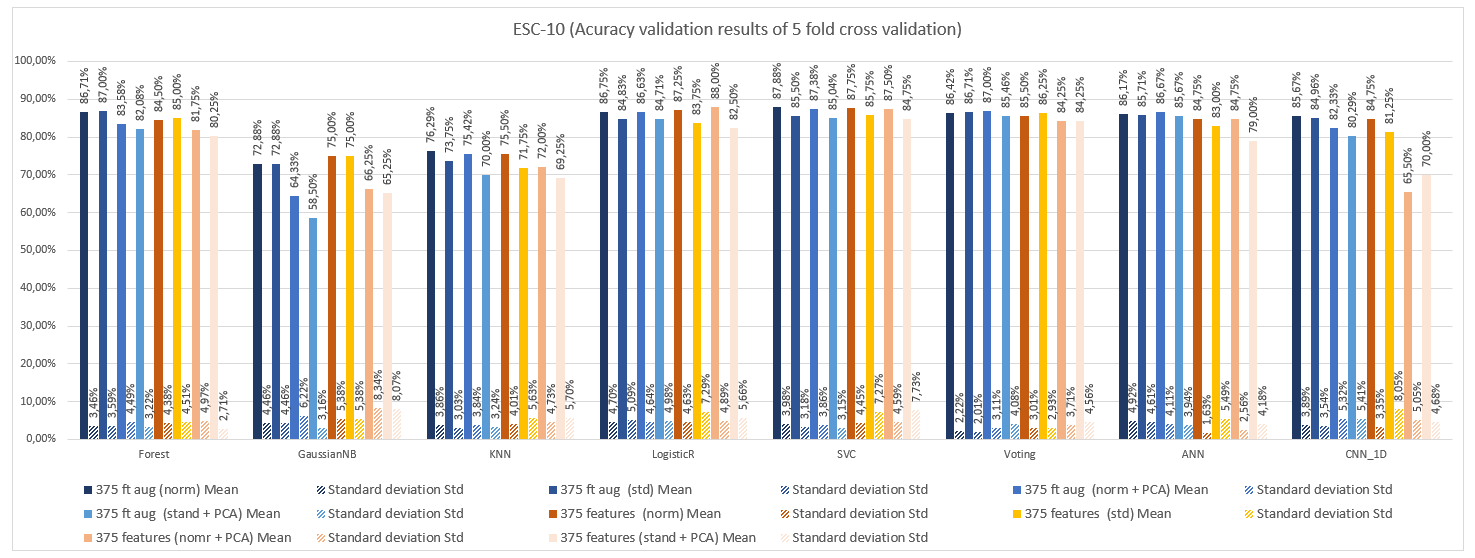

Augmented x Windowed

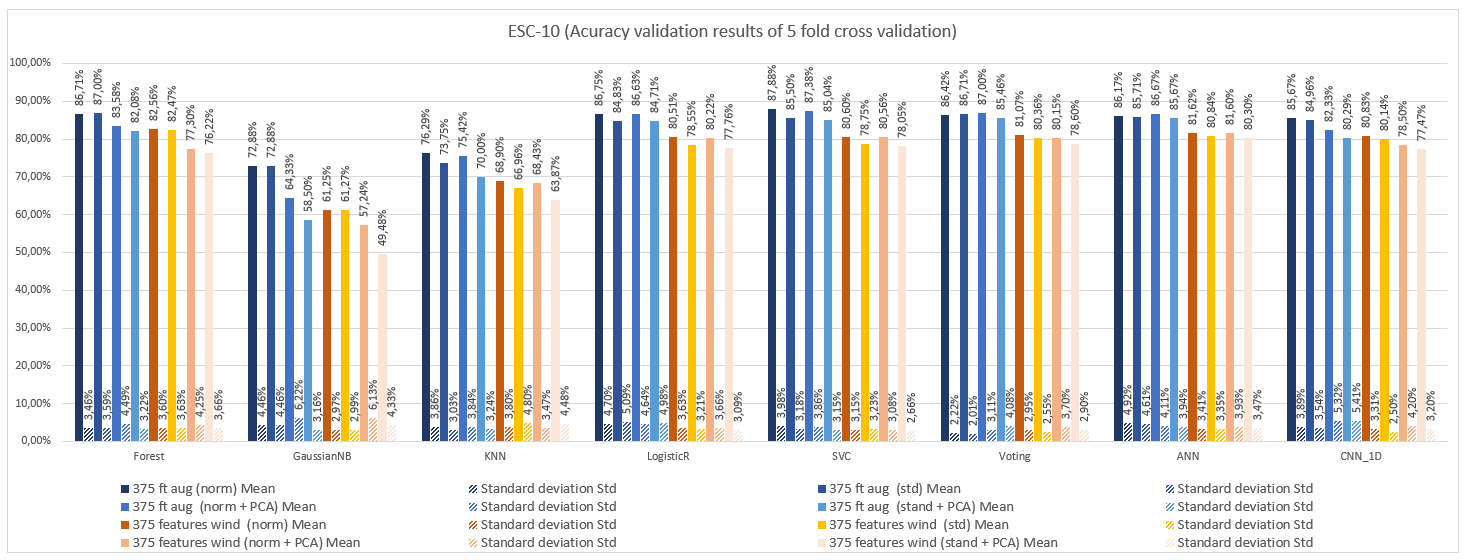

## Results BDLib2 (including the ML results) - Compiled in Excel

Original x Augmented

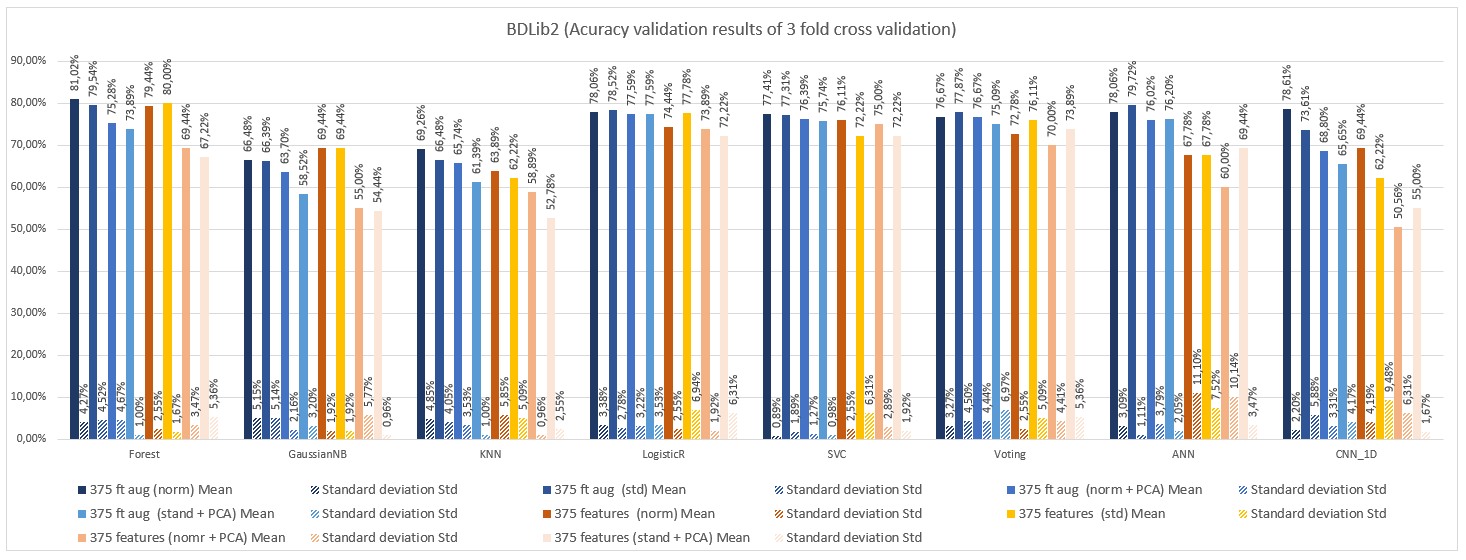

Augmented x Windowed

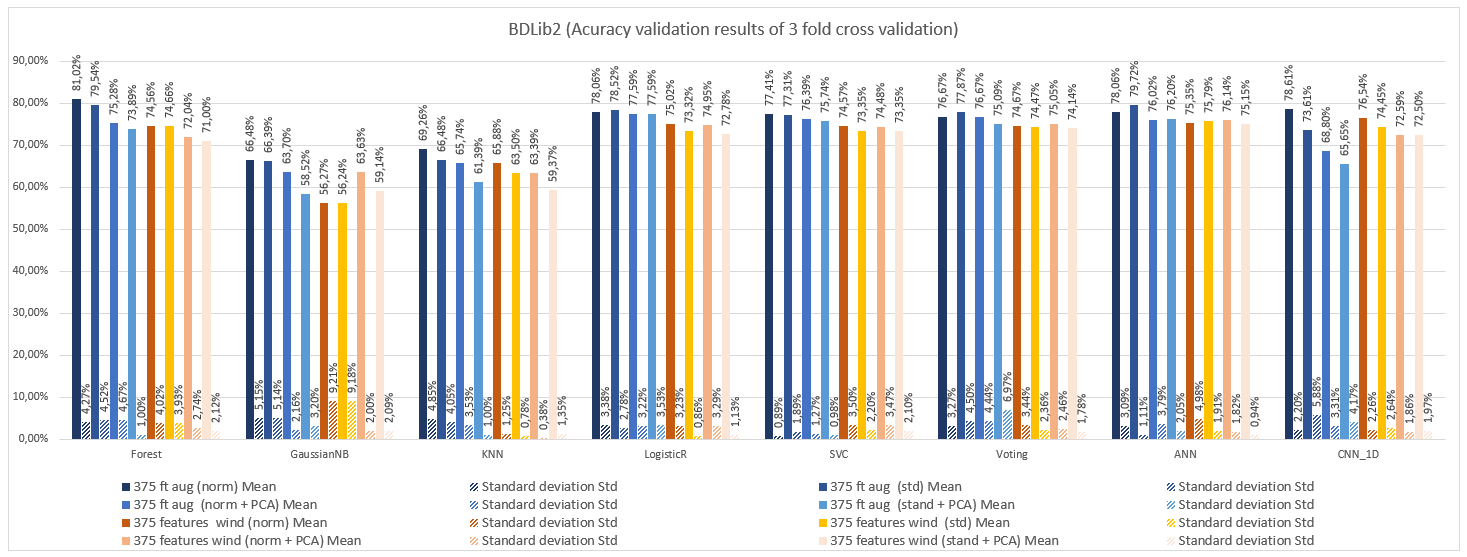

## Results US8K (including the ML results) - Compiled in Excel

Original x Augmented

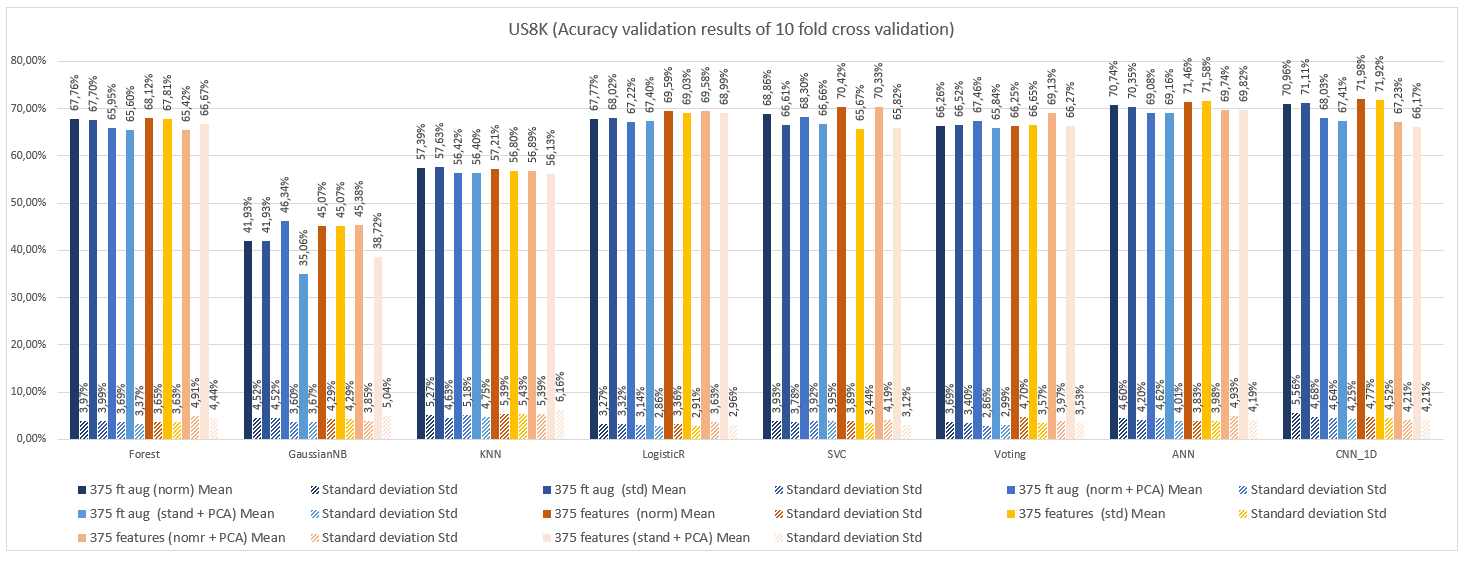

Augmented x Windowed

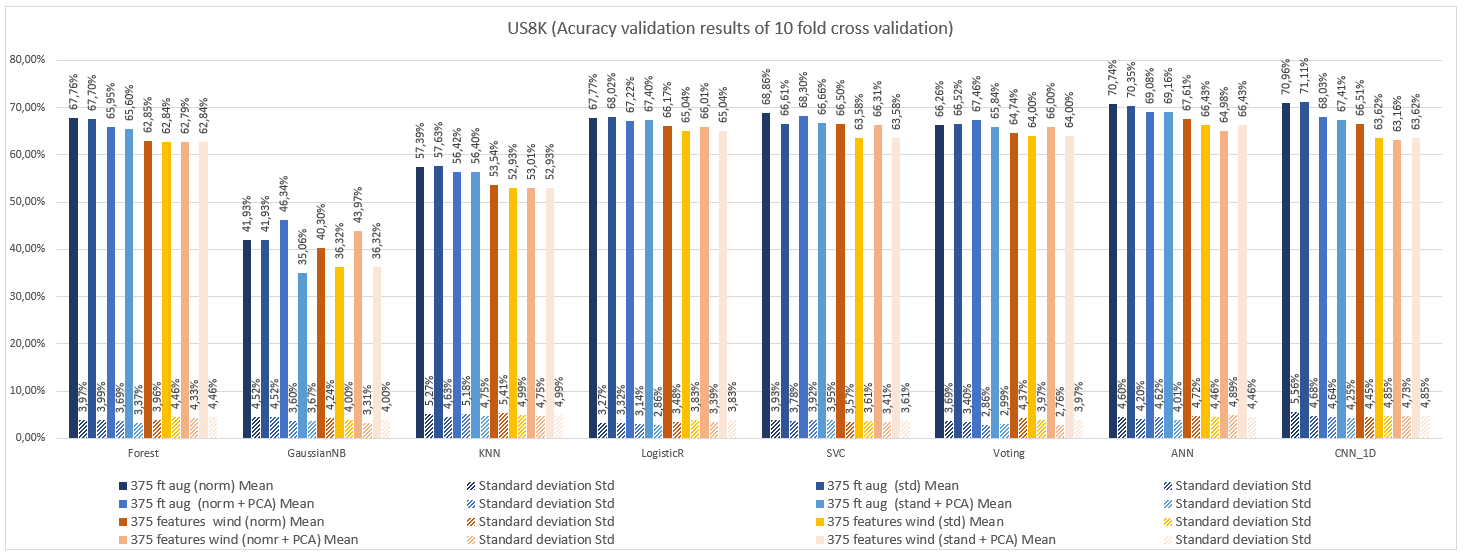

## Results US8K_AV (including the ML results) - Compiled in Excel

Original x Augmented

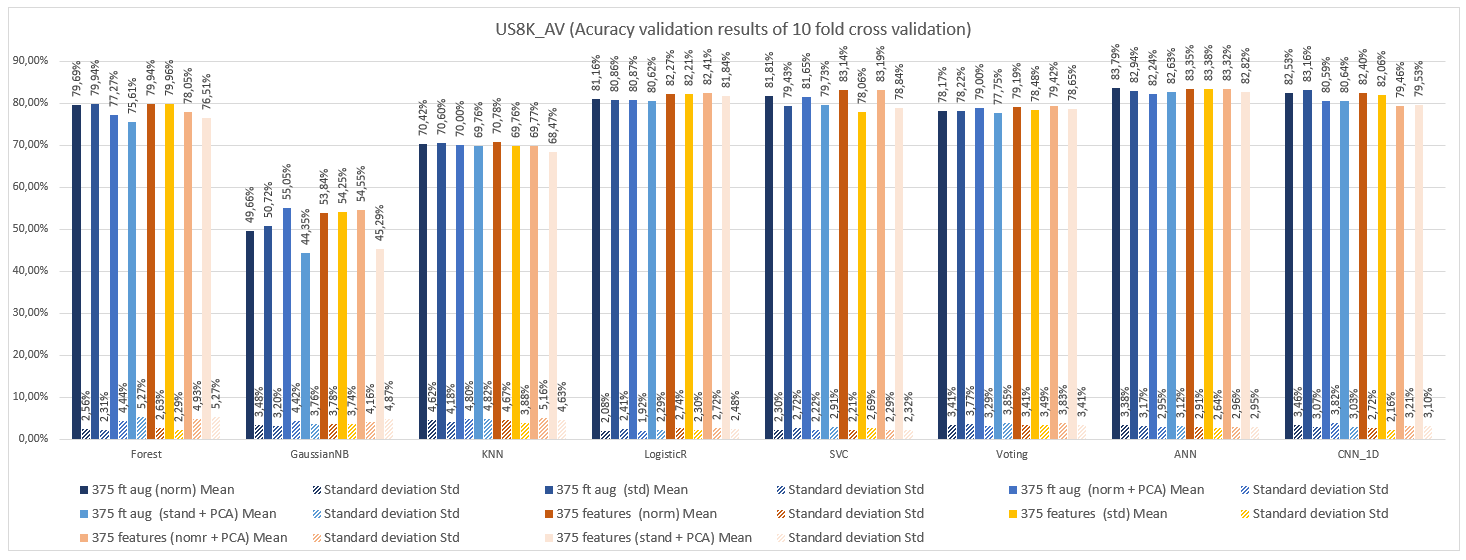

Augmented x Windowed

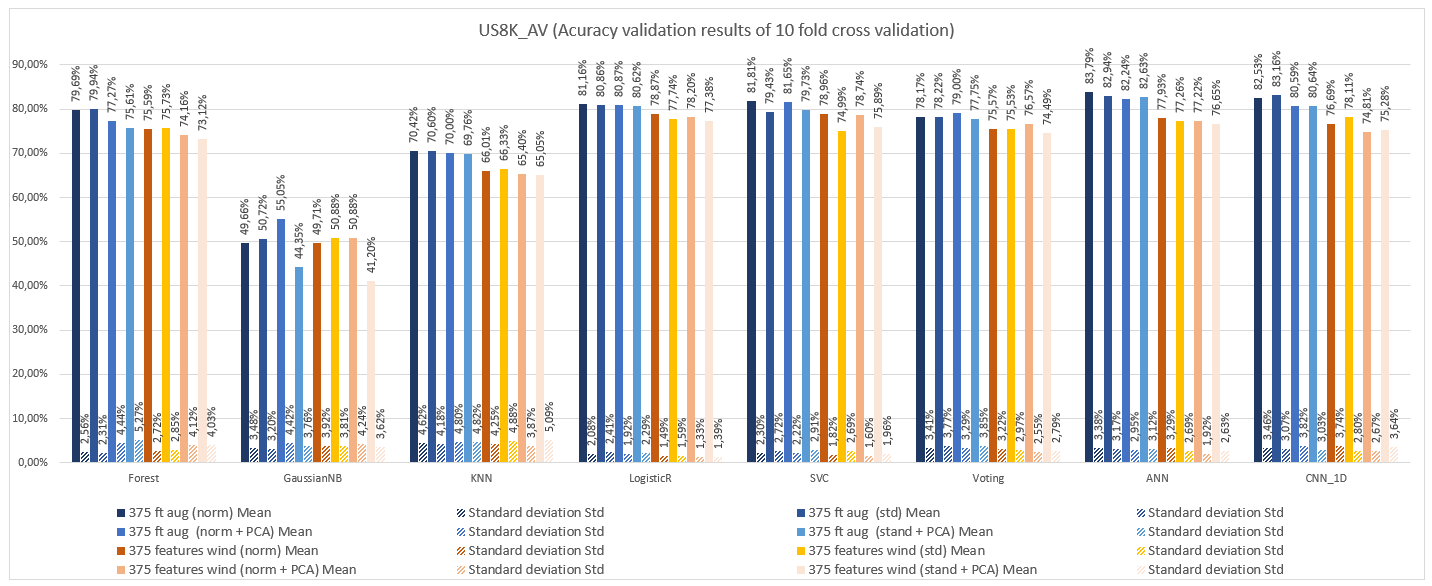

# End of the notebook 

In [ ]:
# 

# 